In [30]:
import pandas as pd
from mlmicrophysics.data import assemble_data_files, subset_data_files_by_date
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import yaml
from os.path import join, exists
%matplotlib inline

In [7]:
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}


In [10]:
config_filename = "/glade/u/home/dgagne/mlmicrophysics/config/cesm_tau_run5_full_train_nn.yml"
with open(config_filename) as config_file:
    config = yaml.load(config_file)
data_path = config["data_path"]
out_path = config["out_path"]
input_cols = config["input_cols"]
output_cols = config["output_cols"]
input_transforms = config["input_transforms"]
output_transforms = config["output_transforms"]
np.random.seed(config["random_seed"])
input_scaler = scalers[config["input_scaler"]]()
#subsample = config["subsample"]
subsample = 0.01
if not exists(out_path):
    os.makedirs(out_path)
train_files, val_files, test_files = subset_data_files_by_date(data_path, "*.csv", **config["subset_data"])
print("Loading training data")
scaled_input_train, \
labels_train, \
transformed_out_train, \
scaled_out_train, \
output_scalers, \
meta_train = assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                     output_transforms, input_scaler, subsample=subsample)

/glade/work/dgagne/ncar_pylib_dl_10/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


[    0    25    50    75   100   125   150   175   200   225   250   275
   300   325   350   375   400   425   450   475   500   525   550   575
   600   625   650   675   700   725   750   775   800   825   850   875
   900   925   950   975  1000  1025  1050  1075  1100  1125  1150  1175
  1200  1225  1250  1275  1300  1325  1350  1375  1400  1425  1450  1475
  1500  1525  1550  1575  1600  1625  1650  1675  1700  1725  1750  1775
  1800  1825  1850  1875  1900  1925  1950  1975  2000  2025  2050  2075
  2100  2125  2150  2175  2200  2225  2250  2275  2300  2325  2350  2375
  2400  2425  2450  2475  2500  2525  2550  2575  2600  2625  2650  2675
  2700  2725  2750  2775  2800  2825  2850  2875  2900  2925  2950  2975
  3000  3025  3050  3075  3100  3125  3150  3175  3200  3225  3250  3275
  3300  3325  3350  3375  3400  3425  3450  3475  3500  3525  3550  3575
  3600  3625  3650  3675  3700  3725  3750  3775  3800  3825  3850  3875
  3900  3925  3950  3975  4000  4025  4050  4075  4

In [15]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).mean()
    return partial_dependence

In [19]:
ls /glade/p/cisl/aiml/dgagne/cam_run5_models_20190726

dnn_classifier_scores.csv  dnn_nr_neg_fortran.nc     input_scale_values.csv
dnn_nc_class.h5            dnn_nr_pos.h5             meta_test.csv
dnn_nc_class_fortran.nc    dnn_nr_pos_fortran.nc     output_scale_values.csv
dnn_nc_pos.h5              dnn_qr_class.h5           test_cam_labels.csv
dnn_nc_pos_fortran.nc      dnn_qr_class_fortran.nc   test_cam_values.csv
dnn_nr_class.h5            dnn_qr_pos.h5             test_prediction_labels.csv
dnn_nr_class_fortran.nc    dnn_qr_pos_fortran.nc     test_prediction_values.csv
dnn_nr_neg.h5              dnn_regressor_scores.csv


In [22]:
dnn_qr_pos = load_model(join("/glade/p/cisl/aiml/dgagne/cam_run5_models_20190726", "dnn_qr_pos.h5"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [25]:
index = np.random.randint(0, scaled_input_train.shape[0], size=50000)

In [34]:
pd_vals = np.arange(-4, 4.1, 0.5)
pd_out = np.zeros((scaled_input_train.shape[1], pd_vals.size))
print(pd_out.shape)
for v in range(pd_out.shape[0]):
    print(v)
    pd_out[v] = partial_dependence_1d(scaled_input_train.loc[index], dnn_qr_pos, v, pd_vals)

(11, 17)
0
1
2
3
4
5
6
7
8
9
10


In [75]:
pd_scaled_in = input_scaler.inverse_transform(np.tile(pd_vals,11).reshape(11, 17).T)

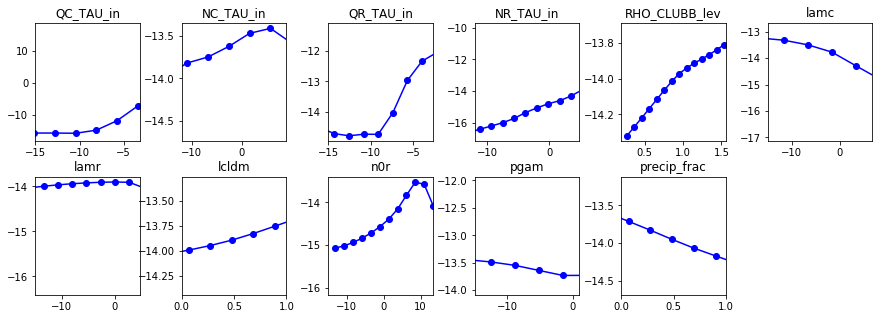

In [102]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
for v in range(pd_out.shape[0]):
    plt.subplot(2, 6, v+1)
    plt.xlim(transformed_input_train[:,v].min(), transformed_input_train[:, v].max())
    plt.plot(pd_scaled_in[:, v], output_scalers["qrtend_TAU"][1].inverse_transform(pd_out[v:v+1].T), 'bo-')
    plt.title(scaled_input_train.columns[v])
plt.savefig("pdp_qr_train_range.png", dpi=200, bbox_inches="tight")

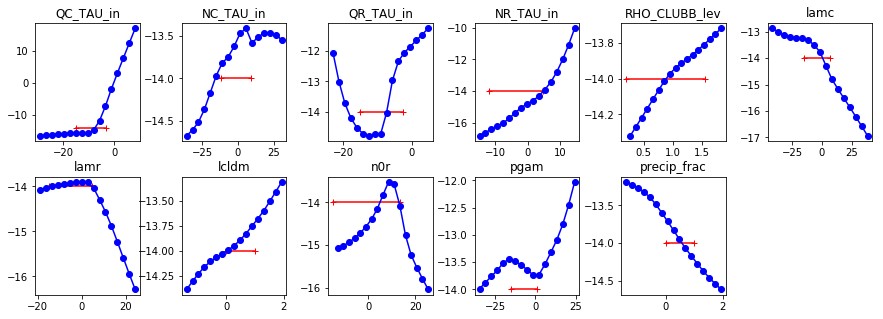

In [101]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
for v in range(pd_out.shape[0]):
    plt.subplot(2, 6, v+1)
    plt.plot([transformed_input_train[:,v].min(), transformed_input_train[:, v].max()], [-14, -14], 'r+-')
    plt.plot(pd_scaled_in[:, v], output_scalers["qrtend_TAU"][1].inverse_transform(pd_out[v:v+1].T), 'bo-')
    plt.title(scaled_input_train.columns[v])
plt.savefig("pdp_qr_extrap_range.png", dpi=200, bbox_inches="tight")

In [86]:
transformed_input_train

NameError: name 'transformed_input_train' is not defined

In [88]:
transformed_input_train = input_scaler.inverse_transform(scaled_input_train)

In [78]:
scaled_input_train.max()

QC_TAU_in        1.556002
NC_TAU_in        1.382424
QR_TAU_in        1.870803
NR_TAU_in        1.355015
RHO_CLUBB_lev    2.597962
lamc             0.843623
lamr             0.369311
lcldm            1.764016
n0r              1.486063
pgam             0.840750
precip_frac      1.729340
dtype: float64

array([[-4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. ],
       [-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5],
       [-3. , -3. , -3. , -3. , -3. , -3. , -3. , -3. , -3. , -3. , -3. ],
       [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5],
       [-2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. ],
       [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5],
       [-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ],
       [ 1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5],
       [ 2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ],
       [ 2.5,  2.5,  2.5,

In [96]:
scaled_out_train.loc[index].mean()

qrtend_TAU   -0.004185
nctend_TAU   -0.005473
nrtend_TAU   -0.007643
dtype: float64